In [14]:
import os
import lib
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, concatenate, Input, Conv2D,Flatten
from tensorflow.keras.backend import clear_session

from importlib import reload
reload(lib)

import warnings
warnings.filterwarnings('ignore')

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Multimodal arquitecture


In [3]:
data_dir = "/home/daielchom/Documents/projects/maestria/data/datasets/leaf_classification/"

In [4]:
split=0.7

In [20]:
X_train_f, _, X_train_ri, y_train, X_test_f, _, X_test_ri, y_test, species, num_classes, _, _ = lib.get_splitted_data(data_dir=data_dir, check_id_sets=True, verbose=1, use_resize_images=True, split=split)

The intersection between train and test set is 0
There are 99 classes for the classification task.


#### flatten images

In [21]:
#X_train_ri = np.array([i.flatten() for i in X_train_ri])
#X_test_ri = np.array([i.flatten() for i in X_test_ri])

#### target onehot

In [22]:
y_train_oh = np.eye(num_classes)[y_train]
y_test_oh  = np.eye(num_classes)[y_test]

In [32]:
X_train_ri = X_train_ri.reshape((X_train_ri.shape[0], X_train_ri.shape[1], X_train_ri.shape[2], 1))

In [33]:
X_train_f.shape, X_train_ri.shape, y_train_oh.shape

((693, 194), (693, 128, 128, 1), (693, 99))

In [34]:
X_test_f.shape, X_test_ri.shape, y_test_oh.shape

((297, 194), (297, 128, 128), (297, 99))

## Only Dense

In [47]:
def model_OD1(input_dim, extra_info_dim, num_classes):
    
    clear_session()
    inp1 = Input(shape=(input_dim[1],input_dim[2],1))
    l11 = Conv2D(10,(3,3), activation="relu")(inp1)
    l12 = Flatten()(l11)

    inp2 = Input(shape=(extra_info_dim,))
    cc1 = concatenate([l12, inp2], axis=1)
    l13 =  Dense(256, activation="relu")(cc1)
    
    output = Dense(num_classes, activation='softmax')(l13)
    #output = Dense(num_classes, activation='softmax')(l12)
        
    #model = Model(inputs=[inp1], outputs=output)
    model = Model(inputs=[inp1, inp2], outputs=output)
    model.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=["accuracy"])
    model.reset_states()
    
    return model



In [48]:
model = model_OD1(input_dim=X_train_ri.shape, extra_info_dim=X_train_f.shape[1], num_classes=num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 126, 126, 10) 100         input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 158760)       0           conv2d[0][0]                     
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 194)]        0                                            
______________________________________________________________________________________________

In [49]:
#history = model.fit(X_train_ri, y_train_oh, epochs=10, batch_size=15)
history = model.fit([X_train_ri, X_train_f], y_train_oh, epochs=10, batch_size=20)

Train on 693 samples
Epoch 1/10
693/693 [==============================] - 21s 30ms/sample - loss: 18.5579 - accuracy: 0.0260
Epoch 2/10
693/693 [==============================] - 19s 27ms/sample - loss: 4.4564 - accuracy: 0.0880
Epoch 3/10
693/693 [==============================] - 19s 27ms/sample - loss: 3.6520 - accuracy: 0.1818
Epoch 4/10
693/693 [==============================] - 19s 27ms/sample - loss: 2.5109 - accuracy: 0.4141
Epoch 5/10
693/693 [==============================] - 20s 28ms/sample - loss: 1.5230 - accuracy: 0.6450
Epoch 6/10
693/693 [==============================] - 19s 28ms/sample - loss: 0.7777 - accuracy: 0.8557
Epoch 7/10
693/693 [==============================] - 20s 29ms/sample - loss: 0.2778 - accuracy: 0.9567
Epoch 8/10
693/693 [==============================] - 22s 32ms/sample - loss: 0.0835 - accuracy: 0.9971
Epoch 9/10
693/693 [==============================] - 20s 29ms/sample - loss: 0.0202 - accuracy: 1.0000
Epoch 10/10
693/693 [=====================

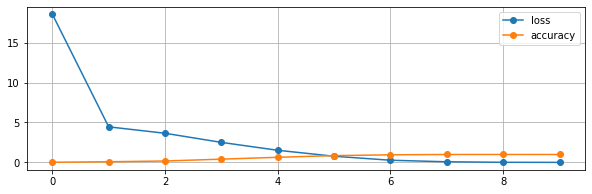

In [50]:
plt.figure(figsize=(10,3))
plt.plot(history.history["loss"], label="loss", marker="o")
plt.plot(history.history["accuracy"], label="accuracy", marker="o")
plt.grid()
plt.legend()